In [41]:
%reset -f
import torch 
from torch import nn
import torch.nn.functional as F 
import torch.optim as optim 
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
import rdkit
from rdkit import Chem
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dgl
import rdkit
from xyz2mol import read_xyz_file, int_atom, xyz2mol
from descriptastorus import DescriptaStore
from descriptastorus.descriptors import rdNormalizedDescriptors, rdDescriptors
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, CanonicalBondFeaturizer
from dgllife.utils import EarlyStopping, Meter, RandomSplitter
from dgl.nn.pytorch import NNConv
from dgl.nn.pytorch import Set2Set
from tqdm.auto import tqdm
from timeit import default_timer as timer
from dgllife.model.gnn.gcn import GCN
from dgllife.model.model_zoo.gcn_predictor import GCNPredictor
from helper_functions import collate_molgraphs, plot_loss_curves,  accuracy_fn, is_valid_class, plot_conf_matrix, plot_roc_auc, is_valid_class_metric_max
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [42]:
class MPNNGNN(nn.Module):
    def __init__(self, node_in_feats, edge_in_feats, node_out_feats=64,
                 edge_hidden_feats=264, num_step_message_passing=6, dropout=0.3):
        super(MPNNGNN, self).__init__()

        self.project_node_feats = nn.Sequential(
            nn.Linear(node_in_feats, node_out_feats),
            nn.Flatten(),
            nn.BatchNorm1d(node_out_feats),
            nn.LeakyReLU(),
            nn.Dropout(dropout)
        )
        self.num_step_message_passing = num_step_message_passing
        edge_network = nn.Sequential(
            nn.Linear(edge_in_feats, edge_hidden_feats),
            nn.LeakyReLU(),
            nn.Linear(edge_hidden_feats, node_out_feats * node_out_feats),
            nn.Dropout(dropout)
        )
        self.gnn_layer = NNConv(
            in_feats=node_out_feats,
            out_feats=node_out_feats,
            edge_func=edge_network,
            aggregator_type='sum'
        )
        self.gru = nn.GRU(node_out_feats, node_out_feats)
        self.func1 = torch.nn.Dropout(dropout)

    def reset_parameters(self):
        """Reinitialize model parameters."""
        self.project_node_feats[0].reset_parameters()
        self.gnn_layer.reset_parameters()
        for layer in self.gnn_layer.edge_func:
            if isinstance(layer, nn.Linear):
                layer.reset_parameters()
        self.gru.reset_parameters()

    def forward(self, g, node_feats, edge_feats):
        node_feats = self.project_node_feats(node_feats)  # (V, node_out_feats)
        hidden_feats = node_feats.unsqueeze(0)            # (1, V, node_out_feats)

        for _ in range(self.num_step_message_passing):
            node_feats = F.leaky_relu(self.gnn_layer(g, node_feats, edge_feats))
            node_feats = self.func1(node_feats)
            node_feats, hidden_feats = self.gru(node_feats.unsqueeze(0), hidden_feats)
            node_feats = node_feats.squeeze(0)

        return node_feats


In [43]:
class MPNNPredictor(nn.Module):

    def __init__(self,
                 node_in_feats,
                 edge_in_feats,
                 node_out_feats=64,
                 edge_hidden_feats=128,
                 n_tasks=1,
                 num_step_message_passing=3,
                 num_step_set2set=6,
                 num_layer_set2set=3,
                 dropout=0.3): 
        super(MPNNPredictor, self).__init__()

        self.gnn = MPNNGNN(node_in_feats=node_in_feats,
                           node_out_feats=node_out_feats,
                           edge_in_feats=edge_in_feats,
                           edge_hidden_feats=edge_hidden_feats,
                           num_step_message_passing=num_step_message_passing, dropout=dropout)
        self.readout = Set2Set(input_dim=node_out_feats,
                               n_iters=num_step_set2set,
                               n_layers=num_layer_set2set)
        self.predict = nn.Sequential(
            nn.Linear(2 * node_out_feats, node_out_feats),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout), 
            nn.Linear(node_out_feats, n_tasks)
        )
        
    def forward(self, g, node_feats, edge_feats):
        node_feats = self.gnn(g, node_feats, edge_feats)
        graph_feats = self.readout(g, node_feats)
        return self.predict(graph_feats)


In [44]:
model_0 = MPNNPredictor(node_in_feats=74 , edge_in_feats=13, edge_hidden_feats=128, num_layer_set2set=3,  num_step_set2set=3, dropout=0.3).to(device)

In [45]:
loss_fn = nn.L1Loss()
learning_rate = 0.0005
optimizer = optim.Adam(params=model_0.parameters(), lr=learning_rate, weight_decay=1e-4)
batch_size = 600
boundary = 2.0
epochs = 70
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
node_featurizer = CanonicalAtomFeaturizer(atom_data_field='h')
edge_featurizer = CanonicalBondFeaturizer(bond_data_field='e', self_loop=True)

In [46]:
import IPython

class MolLoader(Dataset):
    def __init__(self, path, is_test = None, notes_col = None):
        df = pd.read_csv(path)
        if is_test is not None:
            df = df[df['test'] == is_test].reset_index()
        self.smiles = df['smiles']
        self.graph = list(map(lambda x: smiles_to_bigraph(x, node_featurizer=node_featurizer, 
                                                      edge_featurizer=edge_featurizer, add_self_loop=True), 
                                                        df['smiles']))

        self.labels = torch.tensor(df['metric_max'].to_list())
        self.n_samples = len(df['smiles'])
        if notes_col is not None:
            self.notes_col = df[notes_col]
        
    def __getitem__(self, index):
        return (self.smiles[index], self.graph[index], self.labels[index])
    
    def __len__(self):
        return self.n_samples
        
        

In [47]:
main_csv_fname = 'final_mols_PC9_CHEMBL789_full.csv'

train_dataset = MolLoader(main_csv_fname, is_test = False, notes_col = None)

train_loader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True, collate_fn=collate_molgraphs)

test_dataset = MolLoader(main_csv_fname, is_test = True, notes_col = 'notes')

test_loader = DataLoader(dataset=test_dataset,
                             batch_size=len(test_dataset), collate_fn=collate_molgraphs)



In [48]:
len(train_dataset), len(test_dataset)

(5696, 1981)

In [49]:
def regress(model, bg):
    bg = bg.to(device)
    atom_feats, bond_feats = bg.ndata.pop('h'), bg.edata.pop('e')
    atom_feats, bond_feats = atom_feats.to(device), bond_feats.to(device)
    return model(bg.to(device), atom_feats.to(device), bond_feats.to(device))

In [50]:
def train_step(model, data_loader, loss_fn, optimizer):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, batch_data in enumerate(data_loader):
        _, X, y = batch_data
        X, y = X.to(device), y.to(device)
        y = y.to(torch.float32)
        y_pred = regress(model, X)[:,0].to(torch.float32)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_score(is_valid_class_metric_max(y, boundary), is_valid_class_metric_max(y_pred.detach(), boundary)) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    return train_loss, train_acc

In [51]:
def test_step(model, data_loader, loss_fn):
    test_loss, test_acc = 0, 0 
    model.eval()
    with torch.inference_mode():
        for batch_data in data_loader:
            _, X, y = batch_data
            X, y = X.to(device), y.to(device)
            y = y.to(torch.float32)
            test_pred = regress(model, X)[:,0].to(torch.float32)
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            test_acc += accuracy_score(is_valid_class_metric_max(y, boundary), is_valid_class_metric_max(test_pred, boundary)) 
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    return test_loss, test_acc

In [52]:
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn,  epochs):
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                              data_loader=test_dataloader,
                              loss_fn=loss_fn)
        scheduler.step(train_loss)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc*100:.4f}% | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc*100:.4f}%"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [53]:
train_time_start = timer()

model_0_results = train(model=model_0, 
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=epochs)

train_time_end = timer()
total_train_time = print(f'Total train time: {train_time_end - train_time_start}')

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8448 | train_acc: 51.4662% | test_loss: 1.3408 | test_acc: 58.1524%
Epoch: 2 | train_loss: 1.1940 | train_acc: 51.7230% | test_loss: 1.0413 | test_acc: 58.1524%
Epoch: 3 | train_loss: 1.0884 | train_acc: 49.6896% | test_loss: 1.0966 | test_acc: 41.8476%
Epoch: 4 | train_loss: 1.0748 | train_acc: 50.2027% | test_loss: 1.0316 | test_acc: 58.3039%
Epoch: 5 | train_loss: 1.0593 | train_acc: 53.5905% | test_loss: 1.0166 | test_acc: 60.1716%
Epoch: 6 | train_loss: 1.0440 | train_acc: 53.6252% | test_loss: 1.0098 | test_acc: 67.4407%
Epoch: 7 | train_loss: 1.0275 | train_acc: 55.9959% | test_loss: 0.9598 | test_acc: 69.3084%
Epoch: 8 | train_loss: 0.9907 | train_acc: 60.7153% | test_loss: 0.9086 | test_acc: 69.7123%
Epoch: 9 | train_loss: 0.9364 | train_acc: 66.1730% | test_loss: 0.8239 | test_acc: 72.6906%
Epoch: 10 | train_loss: 0.8899 | train_acc: 68.6716% | test_loss: 0.8011 | test_acc: 72.7410%
Epoch: 11 | train_loss: 0.8576 | train_acc: 70.5658% | test_loss: 0.7

In [54]:
figsz = (6, 5)

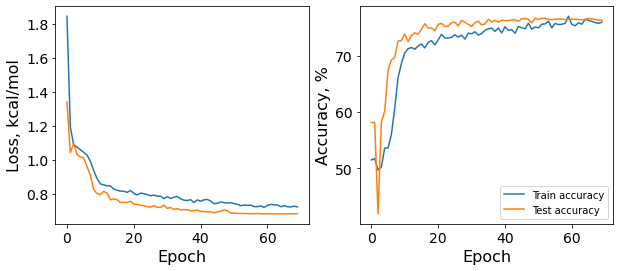

In [55]:
figsz2 = (10, 4)
plot_loss_curves(model_0_results, batch_size=batch_size, learning_rate=learning_rate, figsize = figsz2)
plt.savefig('pictures/loss_and_accuracy_curves.png', dpi=700)

In [56]:
def predict(a):
    with torch.inference_mode():
        model_0.eval()
        smls = smiles_to_bigraph(a, node_featurizer=node_featurizer, edge_featurizer=edge_featurizer, add_self_loop=True)
        return model_0(smls.to(device), smls.ndata.pop('h').to(device), smls.edata.pop('e').to(device)).item()

In [57]:
params_graph = {
    'in_feats': 74,
    'hidden_feats': [512, 256],
    'dropout': [0.45, 0.5],
    'activation': [F.leaky_relu, F.leaky_relu],
    'predictor_hidden_feats': 256,
    'predictor_dropout': 0.5
}



model_1 = GCNPredictor(**params_graph).to(device)


learning_rate = 0.005
optimizer = optim.Adam(params=model_1.parameters(), lr=learning_rate,  weight_decay=1e-2)
batch_size = 500
epochs = 150
bound = 2.0
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, verbose=True)
 
node_featurizer = CanonicalAtomFeaturizer()

def regress(model, bg):
    bg = bg.to(device)
    atom_feats = bg.ndata.pop('h')
    atom_feats = atom_feats.to(device)
    return model(bg.to(device), atom_feats.to(device))

In [58]:
def predict_gcn(a):
    with torch.inference_mode():
        model_1.eval()
        smls = smiles_to_bigraph(a, node_featurizer=node_featurizer, add_self_loop=True)
        return model_1(smls.to(device), smls.ndata.pop('h').to(device)).item()

In [59]:
train_time_start = timer()

model_1_results = train(model=model_1, 
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=epochs)

train_time_end = timer()
total_train_time = print(f'Total train time: {train_time_end - train_time_start}')

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2029 | train_acc: 52.1459% | test_loss: 1.8768 | test_acc: 58.1524%
Epoch: 2 | train_loss: 1.7923 | train_acc: 52.2212% | test_loss: 1.9979 | test_acc: 58.1524%
Epoch: 3 | train_loss: 1.1148 | train_acc: 62.9523% | test_loss: 0.9831 | test_acc: 67.0369%
Epoch: 4 | train_loss: 0.9619 | train_acc: 67.6428% | test_loss: 0.8727 | test_acc: 72.1353%
Epoch: 5 | train_loss: 0.8431 | train_acc: 71.3923% | test_loss: 1.1425 | test_acc: 65.6234%
Epoch: 6 | train_loss: 0.8200 | train_acc: 72.9162% | test_loss: 1.4154 | test_acc: 62.1908%
Epoch: 7 | train_loss: 0.8129 | train_acc: 72.8140% | test_loss: 0.9814 | test_acc: 74.4573%
Epoch: 8 | train_loss: 0.8119 | train_acc: 73.4464% | test_loss: 1.4777 | test_acc: 68.0969%
Epoch: 9 | train_loss: 0.7835 | train_acc: 73.8878% | test_loss: 0.9056 | test_acc: 72.0343%
Epoch: 10 | train_loss: 0.7889 | train_acc: 73.4658% | test_loss: 1.3593 | test_acc: 72.7410%
Epoch: 11 | train_loss: 0.7833 | train_acc: 73.0788% | test_loss: 0.8

Epoch: 88 | train_loss: 0.7025 | train_acc: 77.2045% | test_loss: 0.7487 | test_acc: 75.5679%
Epoch: 89 | train_loss: 0.6987 | train_acc: 77.2500% | test_loss: 0.7334 | test_acc: 76.0727%
Epoch: 90 | train_loss: 0.6999 | train_acc: 76.7973% | test_loss: 0.7288 | test_acc: 76.1736%
Epoch: 91 | train_loss: 0.6981 | train_acc: 76.9324% | test_loss: 0.7761 | test_acc: 75.0126%
Epoch: 92 | train_loss: 0.6966 | train_acc: 77.7018% | test_loss: 0.7466 | test_acc: 75.3155%
Epoch: 93 | train_loss: 0.6975 | train_acc: 77.2820% | test_loss: 0.7132 | test_acc: 76.6280%
Epoch: 94 | train_loss: 0.7064 | train_acc: 76.8338% | test_loss: 0.7321 | test_acc: 75.7698%
Epoch: 95 | train_loss: 0.6940 | train_acc: 76.9306% | test_loss: 0.7333 | test_acc: 75.9717%
Epoch: 96 | train_loss: 0.6916 | train_acc: 77.0194% | test_loss: 0.7208 | test_acc: 76.6280%
Epoch: 97 | train_loss: 0.6907 | train_acc: 77.1554% | test_loss: 0.7340 | test_acc: 75.6689%
Epoch: 98 | train_loss: 0.6901 | train_acc: 77.7667% | test_

In [60]:
def get_test_metrics(df,
    predictors = {'model_mpnn': predict, 'model_gcn': predict_gcn}
):    

    if 0:
        test_graphs = []
        for smiles in df['smiles'].to_list():
            g = smiles_to_bigraph(smiles, node_featurizer=node_featurizer, 
                                  edge_featurizer=edge_featurizer, add_self_loop=True)
            test_graphs.append(g)
        test_labels = torch.tensor(df['metric_max'].to_list())
    predictions = []
    for ismi, smiles in enumerate(df['smiles'].to_list()):
        rec = {}
        for k, p in predictors.items():
            rec[k] = p(smiles)
        predictions.append(rec)
        if ismi%500==0:
            print(ismi, end=' ')
    return predictions

test_df = pd.read_csv(main_csv_fname)
test_df = test_df[test_df['test'] == True].reset_index()

predictions = get_test_metrics(test_df)
predictions[-1]

0 500 1000 1500 

{'model_mpnn': 1.3536416292190552, 'model_gcn': 1.0766597986221313}

In [61]:
predicted_df = pd.concat([test_df, pd.DataFrame(predictions)], axis = 1)
predicted_df

,index,Unnamed: 0,coef,Number of conf,Crest max - min,QC max - min,smiles,metric_max,metric_mean,max_diff,...,omega,file,inchi_key,ChEMBL ID,Heavy Atoms,test,notes,_train_id,model_mpnn,model_gcn
0,3,3,1.000000,-0.487049,0.005196,0.008041,NCc1ccco1,1.318835,0.723580,1.785256,...,0.000000,3438.0,DDRPCXLAQZKBJP,CHEMBL3561633,7.0,True,ChEMBL,NaN,1.267903,1.296441
1,4,4,0.955844,-0.051465,0.009218,0.009905,O=CCCCC=O,1.407707,0.465855,1.628551,...,0.000000,3485.0,SXRSQZLOMIGNAQ,CHEMBL1235482,7.0,True,ChEMBL,NaN,1.815043,1.596231
2,5,5,0.481538,0.064690,0.008196,0.011123,CN[C@@H](C)C(=O)O,4.899466,1.223199,6.203820,...,1.533735,4377.0,GDFAOVXKHJXLEI,NaN,7.0,True,random test from PC9,3.0,3.243596,2.361369
3,6,6,0.769231,-0.312815,0.003472,0.004438,CCN(CC)N=O,1.050980,0.469052,1.196643,...,0.069052,5921.0,WBNQDOYYEUMPFS,CHEMBL164290,7.0,True,ChEMBL,NaN,1.202215,0.974340
4,7,7,0.981818,-0.341854,0.006948,0.013980,[H]/N=C(/N)N=C(N)N,2.808204,1.310002,4.503826,...,0.000000,5939.0,XNCOSPRUTUOJCJ,NaN,7.0,True,random test from PC9,4.0,1.943771,2.081089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976,7672,7672,0.900000,-0.164810,0.008630,0.011251,CCN(O)C(N)=O,1.242915,0.790497,NaN,...,NaN,3274873.0,NaN,NaN,7.0,True,ChEMBL_7,NaN,1.677706,0.893842
1977,7673,7673,0.900000,-0.325105,0.003278,0.006906,OCc1cn[nH]c1,1.870599,0.748239,NaN,...,NaN,3276272.0,NaN,NaN,7.0,True,ChEMBL_7,NaN,1.400715,1.421902
1978,7674,7674,1.000000,-0.405252,0.001747,0.001732,CN1CC=CC1=O,0.004664,0.004664,NaN,...,NaN,3352944.0,NaN,NaN,7.0,True,ChEMBL_7,NaN,0.618249,0.852928
1979,7675,7675,1.000000,-0.405252,0.000958,0.002545,CC#CC(=O)NC,0.498483,0.498483,NaN,...,NaN,3352947.0,NaN,NaN,7.0,True,ChEMBL_7,NaN,0.789627,0.739854


In [62]:
generator = rdDescriptors.RDKit2D()

def smiles_to_normalized_features(smiles):
    results = generator.process(smiles)
    processed, features = results[0], results[1:]
    if processed is None:
        pass
    return features

def make_descriptors(dataframe):
    new_cols = dataframe['smiles'].apply(smiles_to_normalized_features).apply(pd.Series)
    new_cols.columns = [f'Desc_{i+1}' for i in range(200)]
    dataframe = pd.concat([dataframe, new_cols], axis=1)
    return dataframe

In [63]:
train_df = pd.read_csv('final_mols_PC9_CHEMBL789_full.csv')
train_df = train_df[train_df['test'] != True]

predicted_df = make_descriptors(predicted_df)
train_df = make_descriptors(train_df)
predicted_df.head(2)

,index,Unnamed: 0,coef,Number of conf,Crest max - min,QC max - min,smiles,metric_max,metric_mean,max_diff,...,Desc_191,Desc_192,Desc_193,Desc_194,Desc_195,Desc_196,Desc_197,Desc_198,Desc_199,Desc_200
0,3,3,1.000000,-0.487049,0.005196,0.008041,NCc1ccco1,1.318835,0.723580,1.785256,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.560914
1,4,4,0.955844,-0.051465,0.009218,0.009905,O=CCCCC=O,1.407707,0.465855,1.628551,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.381710


In [64]:
train_df

,Unnamed: 0,coef,Number of conf,Crest max - min,QC max - min,smiles,metric_max,metric_mean,max_diff,mean_diff,...,Desc_191,Desc_192,Desc_193,Desc_194,Desc_195,Desc_196,Desc_197,Desc_198,Desc_199,Desc_200
0,0,1.000000,-0.574166,0.004387,0.005052,O=CCCl,0.981708,0.654472,1.262609,0.560072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.328271
1,1,0.811100,1.807025,0.009392,0.013746,CC(N)(CO)CO,2.323624,0.894461,3.843868,1.634062,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.408164
2,2,0.895604,-0.283777,0.004759,0.007687,NC/C=C/C(=O)O,1.437979,0.819962,2.349967,0.955780,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.464420
8,8,0.107143,-0.458010,0.003103,0.008162,CC(C)(N)C(=O)O,4.043745,1.230064,5.333721,4.040590,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.483075
15,15,0.468696,0.035651,0.006952,0.010204,CC[C@H](N)C(=O)O,4.667772,1.136811,6.256708,4.573080,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.508726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7091,7091,1.000000,-0.603204,0.003572,0.000606,O=P(F)(F)OO,0.931532,0.931532,1.861610,0.930805,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.322216
7092,7092,1.000000,-0.603204,0.002112,0.002669,N#CNSO,0.174796,0.174796,0.349319,0.174660,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.208540
7093,7093,1.000000,-0.603204,0.002598,0.001508,N#CSC(=O)C#N,0.342410,0.342410,0.684286,0.342143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.332563
7094,7094,1.000000,-0.603204,0.001080,0.000667,N#C/N=N/[N+](=O)[O-],0.129774,0.129774,0.259345,0.129672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.202404


In [65]:
from sklearn.ensemble import GradientBoostingRegressor

train_df.dropna(subset=list(i for i in train_df.columns)[20:], inplace=True)
predicted_df.dropna(subset=list(i for i in predicted_df.columns)[24:], inplace=True)


params = {
    'n_estimators': 1000,  
    'learning_rate': 0.1, 
    'max_depth': 8,  
    'min_samples_split': 5,  
    'min_samples_leaf': 2  
}

model_2 = GradientBoostingRegressor(**params)
model_2.fit(train_df[list(i for i in train_df.columns)[18:]].values.reshape(-1, 200), y=train_df['metric_max'].values)
predicted_df['model_gb'] = model_2.predict(predicted_df[list(i for i in predicted_df.columns)[21:]].values.reshape(-1, 200))

In [66]:
def find_beta(list_of_models):
    X = predicted_df[list_of_models].to_numpy()
    return np.squeeze(np.linalg.solve(X.T.dot(X) + lmbd * np.identity(X.shape[1]), X.T.dot(y)))

In [67]:
lmbd = 100
y = predicted_df['metric_max'].to_numpy()[:, np.newaxis]


beta_mpnn_gcn_gb_MPNN, beta_mpnn_gcn_gb_GCN, beta_mpnn_gcn_gb_GB = find_beta(['model_mpnn', 'model_gcn', 'model_gb'])
beta_mpnn_gcn_MPNN, beta_mpnn_gcn_GCN = find_beta(['model_mpnn', 'model_gcn'])
beta_mpnn_gb_MPNN, beta_mpnn_gb_GB = find_beta(['model_mpnn', 'model_gb'])
beta_gcn_gb_GCN, beta_gcn_gb_GB = find_beta(['model_gcn', 'model_gb'])



In [68]:
predicted_df['MPNN_GCN_GB'] = predicted_df['model_mpnn']*beta_mpnn_gcn_gb_MPNN + predicted_df['model_gcn']*beta_mpnn_gcn_gb_GCN + predicted_df['model_gb']*beta_mpnn_gcn_gb_GB
predicted_df['MPNN_GCN'] = predicted_df['model_mpnn']*beta_mpnn_gcn_MPNN + predicted_df['model_gcn']*beta_mpnn_gcn_GCN
predicted_df['MPNN_GB'] = predicted_df['model_mpnn']*beta_mpnn_gb_MPNN + predicted_df['model_gb']*beta_mpnn_gb_GB
predicted_df['GCN_GB'] = predicted_df['model_gcn']*beta_gcn_gb_GCN + predicted_df['model_gb']*beta_gcn_gb_GB


predicted_df.head()

,index,Unnamed: 0,coef,Number of conf,Crest max - min,QC max - min,smiles,metric_max,metric_mean,max_diff,...,Desc_196,Desc_197,Desc_198,Desc_199,Desc_200,model_gb,MPNN_GCN_GB,MPNN_GCN,MPNN_GB,GCN_GB
0,3,3,1.000000,-0.487049,0.005196,0.008041,NCc1ccco1,1.318835,0.723580,1.785256,...,0.0,0.0,0.0,0.0,0.560914,1.306803,1.364475,1.431395,1.272622,1.446745
1,4,4,0.955844,-0.051465,0.009218,0.009905,O=CCCCC=O,1.407707,0.465855,1.628551,...,0.0,0.0,2.0,0.0,0.381710,2.642206,2.068385,1.908476,2.062900,2.114879
2,5,5,0.481538,0.064690,0.008196,0.011123,CN[C@@H](C)C(=O)O,4.899466,1.223199,6.203820,...,0.0,0.0,0.0,0.0,0.503200,3.302943,3.151284,3.144581,3.243115,2.933042
3,6,6,0.769231,-0.312815,0.003472,0.004438,CCN(CC)N=O,1.050980,0.469052,1.196643,...,0.0,0.0,0.0,0.0,0.393230,1.876398,1.374949,1.219188,1.405858,1.376029
4,7,7,0.981818,-0.341854,0.006948,0.013980,[H]/N=C(/N)N=C(N)N,2.808204,1.310002,4.503826,...,0.0,0.0,0.0,0.0,0.211961,2.818363,2.339998,2.245081,2.205695,2.555030


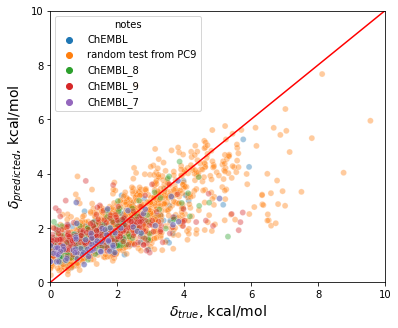

In [69]:
import seaborn as sns
from sklearn.metrics import r2_score
plt.figure(figsize=figsz)
g = sns.scatterplot(predicted_df, y='MPNN_GCN_GB', x='metric_max', hue='notes', alpha=0.4)
g.set(xlim=(0, 10))
g.set(ylim=(0, 10))
X_plot = np.linspace(0,50)
Y_plot = X_plot
plt.plot(X_plot, Y_plot, color='r')
g.set(ylabel='$\delta_{predicted}$, kcal/mol')
g.set(xlabel='$\delta_{true}$, kcal/mol')
g.xaxis.get_label().set_fontsize(14)  
g.yaxis.get_label().set_fontsize(14)  
plt.savefig('pictures/visualize_precision.png', dpi=700, bbox_inches='tight')

In [70]:
def check_accuracy(col1, col2):
    real = (col1 > 2.0).astype(int)
    predicted = (col2 > 2.0).astype(int)
    percent_same = (real == predicted).mean() * 100
    return f"{percent_same:.2f}" 

In [71]:
fltr_7 = (predicted_df['notes'] == "random test from PC9") | (predicted_df['notes'] == "ChEMBL")
predicted_df_7 = predicted_df[fltr_7] 
predicted_pc9 = predicted_df[predicted_df['notes'] == "random test from PC9"]
predicted_chembl_7 = predicted_df[predicted_df['notes'] == "ChEMBL"]
predicted_chembl_8 = predicted_df[predicted_df['notes'] == "ChEMBL_8"]
predicted_chembl_9 = predicted_df[predicted_df['notes'] == "ChEMBL_9"]
predicted_all_chembl = pd.concat([predicted_chembl_7, predicted_chembl_8, predicted_chembl_9], axis=0)

<AxesSubplot:xlabel='metric_max', ylabel='Count'>

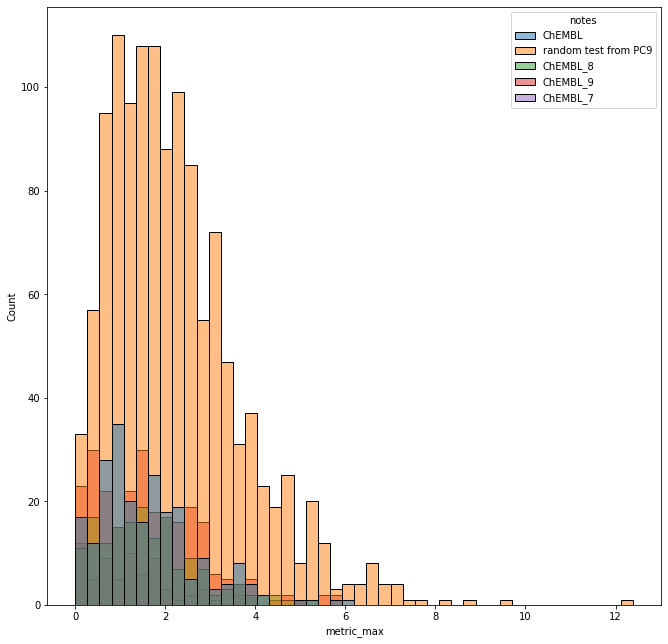

In [72]:
plt.figure(figsize=(11, 11))
sns.histplot(data=predicted_df, x='metric_max', hue='notes')

In [73]:
import scipy.stats as st

models = ['model_mpnn', 'model_gcn', 'model_gb', 'MPNN_GCN', 'MPNN_GB','GCN_GB', 'MPNN_GCN_GB']
datasets_dict = {'7 atoms PC9+ChEMBL':predicted_df_7, '7 atoms PC9':predicted_pc9, '7 atoms ChEMBL':predicted_chembl_7, '8 atoms ChEMBL':predicted_chembl_8, '9 atoms ChEMBL':predicted_chembl_9, '7,8,9 atoms ChEMBL':predicted_all_chembl}

In [74]:
def remove_underscore(input_string):
    if isinstance(input_string, str):
        return input_string.replace('_', ' ')
    elif isinstance(input_string, list):
        return [s.replace('_', ' ') for s in input_string]
    else:
        raise TypeError("Input should be a string or a list of strings")

In [75]:
spearman_table = pd.DataFrame(columns=datasets_dict, index=remove_underscore(models))

for model in models:
    for dataset in datasets_dict.keys():
        spearman_table.at[remove_underscore(model), dataset] = round(st.spearmanr(datasets_dict[dataset]['metric_max'], datasets_dict[dataset][model])[0], 2)
        
spearman_table

,7 atoms PC9+ChEMBL,7 atoms PC9,7 atoms ChEMBL,8 atoms ChEMBL,9 atoms ChEMBL,"7,8,9 atoms ChEMBL"
model mpnn,0.72,0.73,0.62,0.63,0.57,0.58
model gcn,0.73,0.73,0.63,0.54,0.5,0.54
model gb,0.75,0.76,0.62,0.47,0.26,0.35
MPNN GCN,0.74,0.74,0.67,0.61,0.56,0.59
MPNN GB,0.76,0.77,0.66,0.63,0.51,0.59
GCN GB,0.77,0.77,0.68,0.6,0.47,0.56
MPNN GCN GB,0.77,0.77,0.69,0.63,0.51,0.6


In [76]:
kendall_table = pd.DataFrame(columns=datasets_dict, index=remove_underscore(models))

for model in models:
    for dataset in datasets_dict.keys():
        kendall_table.at[remove_underscore(model), dataset] = round(st.kendalltau(datasets_dict[dataset]['metric_max'], datasets_dict[dataset][model])[0], 2)
        
kendall_table

,7 atoms PC9+ChEMBL,7 atoms PC9,7 atoms ChEMBL,8 atoms ChEMBL,9 atoms ChEMBL,"7,8,9 atoms ChEMBL"
model mpnn,0.54,0.54,0.46,0.46,0.41,0.41
model gcn,0.54,0.54,0.47,0.39,0.35,0.38
model gb,0.56,0.57,0.45,0.34,0.17,0.25
MPNN GCN,0.55,0.56,0.49,0.45,0.39,0.42
MPNN GB,0.57,0.58,0.48,0.45,0.35,0.42
GCN GB,0.58,0.58,0.5,0.43,0.33,0.4
MPNN GCN GB,0.58,0.58,0.51,0.45,0.36,0.43


In [77]:
accuracy_table = pd.DataFrame(columns=datasets_dict, index=remove_underscore(models))

for model in models:
    for dataset in datasets_dict.keys():
        accuracy_table.at[remove_underscore(model), dataset] = check_accuracy(datasets_dict[dataset]['metric_max'], datasets_dict[dataset][model])
        
accuracy_table

,7 atoms PC9+ChEMBL,7 atoms PC9,7 atoms ChEMBL,8 atoms ChEMBL,9 atoms ChEMBL,"7,8,9 atoms ChEMBL"
model mpnn,77.53,76.94,80.79,78.12,65.23,73.95
model gcn,76.79,76.55,78.17,75.62,66.41,72.87
model gb,80.01,80.03,79.91,53.12,38.67,56.90
MPNN GCN,77.93,77.65,79.48,80.00,66.41,74.42
MPNN GB,80.68,80.11,83.84,80.62,73.44,78.91
GCN GB,80.21,79.71,82.97,74.38,74.61,77.52
MPNN GCN GB,79.61,79.32,81.22,79.38,76.17,78.76


In [78]:
r2_table = pd.DataFrame(columns=datasets_dict, index=remove_underscore(models))

for model in models:
    for dataset in datasets_dict.keys():
        r2_table.at[remove_underscore(model), dataset] = r2_score(datasets_dict[dataset]['metric_max'], datasets_dict[dataset][model])
        
r2_table

,7 atoms PC9+ChEMBL,7 atoms PC9,7 atoms ChEMBL,8 atoms ChEMBL,9 atoms ChEMBL,"7,8,9 atoms ChEMBL"
model mpnn,0.520916,0.510911,0.485203,0.393465,0.157159,0.322113
model gcn,0.432313,0.413512,0.460861,0.254479,0.048156,0.234604
model gb,0.512274,0.50405,0.455891,-0.375932,-1.539051,-0.600038
MPNN GCN,0.541712,0.531722,0.511815,0.398,0.183355,0.343429
MPNN GB,0.564107,0.55595,0.521953,0.454563,0.181898,0.359285
GCN GB,0.560621,0.5504,0.538533,0.367803,0.138499,0.325987
MPNN GCN GB,0.570487,0.561427,0.53938,0.436858,0.198004,0.368008


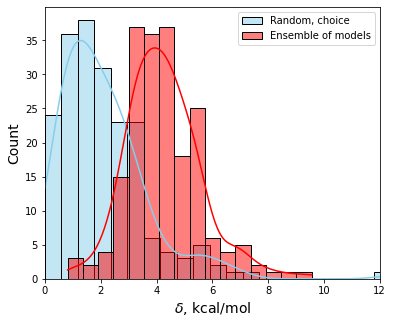

In [79]:
fraction = 0.1
plt.figure(figsize=figsz)
frac = int(len(predicted_df)*fraction)
df_random = predicted_df.sample(frac=fraction)
df_sorted = predicted_df.sort_values(by=['MPNN_GCN_GB'], ascending=False).head(frac)
sns.histplot(df_random['metric_max'], label='Random, choice', color="skyblue", kde=True)
sns.histplot(df_sorted['metric_max'], label='Ensemble of models', color="red", kde=True)
plt.xlabel("$\delta$, kcal/mol", fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlim((0, 12))
plt.legend() 
plt.savefig('pictures/histogram_random_and_sorted1.png', dpi=700, bbox_inches='tight')
plt.show()



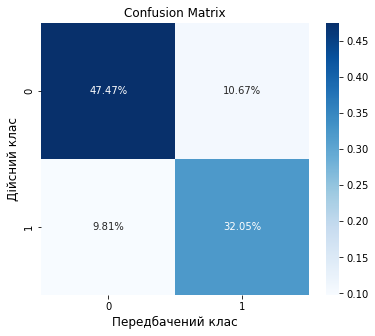

In [80]:
predicted_df['Predicted_class'] = (predicted_df['MPNN_GCN_GB']>=boundary).astype(int)
predicted_df['Real_class'] = (predicted_df['metric_max']>=boundary).astype(int)

plt.figure(figsize=figsz)
plot_conf_matrix(predicted_df['Real_class'], predicted_df['Predicted_class'])
plt.xlabel("Передбачений клас", fontsize=12)
plt.ylabel('Дійсний клас', fontsize=12)
plt.savefig('pictures/conf_matrix.png', dpi=700)

In [81]:
feature_importances = model_2.feature_importances_
feature_importance = {}

for feature_name, importance in zip(train_df[list(i for i in train_df.columns)[20:]], feature_importances):
    feature_importance[feature_name] = importance
    
df_feature = pd.DataFrame.from_dict(feature_importance, orient="index")
df_feature.columns = ['importance']
df_feature.sort_values(by='importance', ascending=False)

,importance
Desc_61,0.138947
Desc_52,0.066849
Desc_64,0.065596
Desc_39,0.040133
Desc_38,0.027212
...,...
Desc_150,0.000000
Desc_105,0.000000
Desc_141,0.000000
Desc_181,0.000000


In [82]:
top_20_mols = predicted_df.sort_values(by='metric_max', ascending=False)['smiles'].head(20).to_list()
top_20_mols_chembl_predicted = predicted_chembl_9.sort_values(by='MPNN_GCN_GB', ascending=False)['smiles'].head(20).to_list()

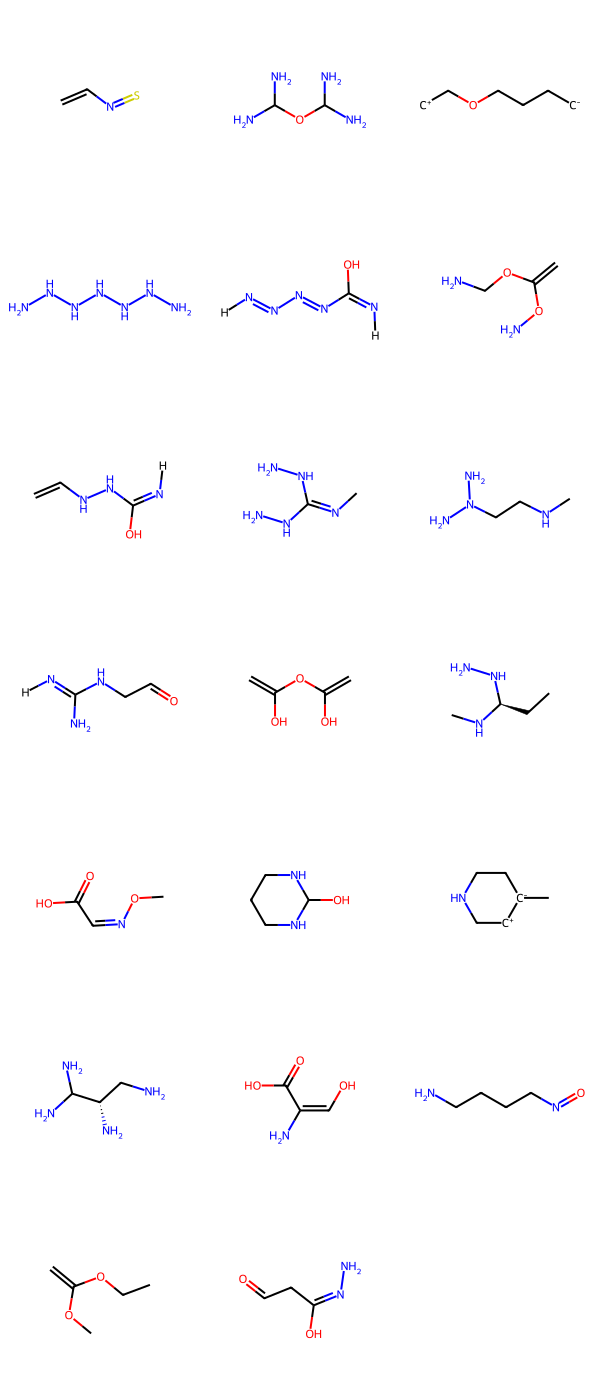

In [83]:
from PIL import Image
from rdkit.Chem import Draw
rd_mols = list(map(Chem.MolFromSmiles, top_20_mols))
img = Draw.MolsToGridImage(rd_mols)
img

In [85]:
predicted_df[predicted_df['notes'] == "ChEMBL_9"]

,index,Unnamed: 0,coef,Number of conf,Crest max - min,QC max - min,smiles,metric_max,metric_mean,max_diff,...,Desc_198,Desc_199,Desc_200,model_gb,MPNN_GCN_GB,MPNN_GCN,MPNN_GB,GCN_GB,Predicted_class,Real_class
1583,7279,7279,NaN,NaN,NaN,NaN,CCc1c[nH]c(C=O)c1,1.193611,NaN,NaN,...,0.0,0.0,0.592046,2.836442,1.398216,0.904011,1.460043,1.528783,0,0
1584,7280,7280,NaN,NaN,NaN,NaN,N#CCCOCCC#N,3.800359,NaN,NaN,...,4.0,0.0,0.521359,7.529373,3.243187,1.719826,3.586315,3.422209,1,1
1585,7281,7281,NaN,NaN,NaN,NaN,O/N=C/C1=CC=CCC1,2.846318,NaN,NaN,...,0.0,0.0,0.321183,3.922161,2.265753,1.693514,2.421223,2.265689,1,1
1586,7282,7282,NaN,NaN,NaN,NaN,Nc1c(O)cccc1O,4.862746,NaN,NaN,...,0.0,0.0,0.352562,3.838763,2.078479,1.479604,2.162322,2.213355,1,1
1587,7283,7283,NaN,NaN,NaN,NaN,O=NN1CCC(O)CC1,5.679889,NaN,NaN,...,0.0,0.0,0.512929,3.829014,2.217161,1.683528,2.252246,2.393354,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1834,7530,7530,NaN,NaN,NaN,NaN,CNc1ccccc1O,2.619906,NaN,NaN,...,0.0,0.0,0.553555,2.630070,1.471796,1.086089,1.495601,1.604684,0,1
1835,7531,7531,NaN,NaN,NaN,NaN,Cc1cc(O)[nH]c(=O)c1,2.183458,NaN,NaN,...,0.0,0.0,0.526577,2.626061,1.509784,1.157221,1.445332,1.767617,0,1
1836,7532,7532,NaN,NaN,NaN,NaN,Cn1ccc(=O)c(O)n1,0.303504,NaN,NaN,...,0.0,0.0,0.508811,2.427733,1.375151,1.021411,1.417079,1.463774,0,0
1837,7533,7533,NaN,NaN,NaN,NaN,Nc1nc[nH]c(=O)c1N,1.025901,NaN,NaN,...,0.0,0.0,0.412093,2.573261,1.460984,1.095647,1.463268,1.618256,0,0


In [86]:
def check_predicted_class(smiles):
    return predicted_df.loc[predicted_df['smiles'] == smiles, 'Predicted_class'].values[0]

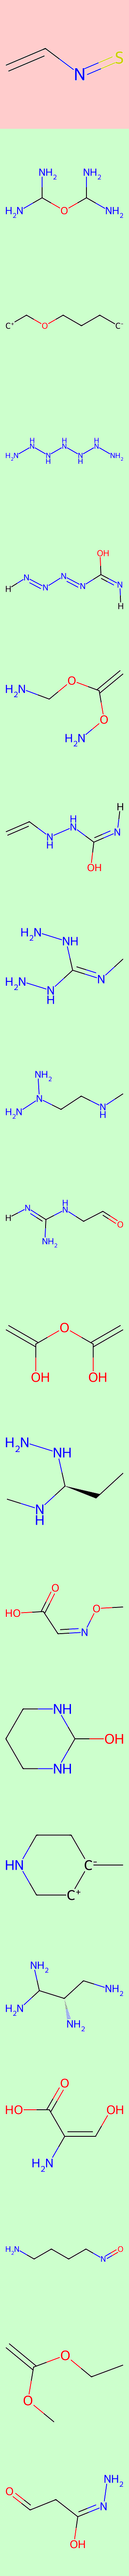

In [87]:
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image

top_20_mols = predicted_df.sort_values(by='metric_max', ascending=False)['smiles'].head(20).to_list()

molecules = list(map(Chem.MolFromSmiles, top_20_mols))
green = (204, 255, 204)
red = (255, 204, 204)

background_colors = [green if check_predicted_class(smls) else red for smls in top_20_mols]

images = []
for mol, color in zip(molecules, background_colors):
    img = Draw.MolToImage(mol, size=(300, 300))
    img = img.convert('RGBA')
    data = img.getdata()

    new_data = []
    for item in data:
        if item[:3] == (255, 255, 255):
            new_data.append((color[0], color[1], color[2], 255))
        else:
            new_data.append(item)
    img.putdata(new_data)
    images.append(img)

width = max([img.size[0] for img in images])
height = sum([img.size[1] for img in images])
combined_image = Image.new('RGBA', (width, height), (255, 255, 255, 0))

y_offset = 0
for img in images:
    combined_image.paste(img, (0, y_offset))
    y_offset += img.size[1]

combined_image


In [88]:
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image

top_20_mols = predicted_df.sort_values(by='metric_max', ascending=False)['smiles'].head(20).to_list()

molecules = list(map(Chem.MolFromSmiles, top_20_mols))
green = (204, 255, 204)
red = (255, 204, 204)

background_colors = [green if check_predicted_class(smls) else red for smls in top_20_mols]

for i, (mol, color) in enumerate(zip(molecules, background_colors)):
    img = Draw.MolToImage(mol, size=(300, 300))
    img = img.convert('RGBA')
    data = img.getdata()

    new_data = []
    for item in data:
        if item[:3] == (255, 255, 255):
            new_data.append((color[0], color[1], color[2], 255))
        else:
            new_data.append(item)
    img.putdata(new_data)
    img.save(f'pictures/mols/picture_{i+1}.png', 'PNG')



In [89]:
from PIL import ImageDraw

combined_image = Image.new('RGB', (5 * 300 + 4, 4 * 300 + 4), (255, 255, 255))
draw = ImageDraw.Draw(combined_image)

x_offset = 0
y_offset = 0

line_color = (255, 255, 255)
line_width = 4

for i in range(20):
    image_path = f'pictures/mols/picture_{i+1}.png'
    img = Image.open(image_path)
    img = img.resize((300, 300))
    
    combined_image.paste(img, (x_offset, y_offset))
    
    draw.rectangle([(x_offset + 300, y_offset), (x_offset + 300 + line_width, y_offset + 300)], fill=line_color)
    
    x_offset += 304
    
    if x_offset == 5 * 304:
        x_offset = 0
        y_offset += 304
        
        draw.rectangle([(x_offset, y_offset + 300), (x_offset + 5 * 304, y_offset + 300 + line_width)], fill=line_color)

combined_image

combined_image.save('pictures/mols/combined_image.png', 'PNG', dpi=(700, 700))



In [90]:
aaa = (7.7, 3)
fz = 10

Text(0.5, 0, 'Number of hydrogen bond donors')

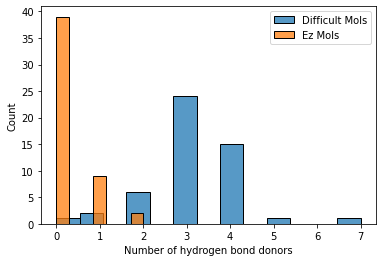

In [91]:
top_50_mols_for_descs = predicted_df.sort_values(by='MPNN_GCN_GB', ascending=False).head(50)
down_50_mols_for_descs = predicted_df.sort_values(by='MPNN_GCN_GB', ascending=True).head(50)
sns.histplot(top_50_mols_for_descs['Desc_59'], label='Difficult Mols')
sns.histplot(down_50_mols_for_descs['Desc_59'], label='Ez Mols')
plt.legend()

plt.xlabel("Number of hydrogen bond donors")

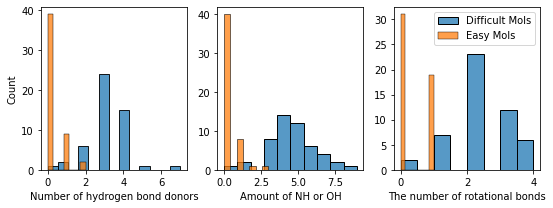

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=aaa)

sns.histplot(top_50_mols_for_descs['Desc_59'], label='Difficult Mols', ax=axes[0])
sns.histplot(down_50_mols_for_descs['Desc_59'], label='Ez Mols', ax=axes[0])
axes[0].set_xlabel("Number of hydrogen bond donors", fontsize=fz)
axes[0].set_ylabel("Count", fontsize=fz)


sns.histplot(top_50_mols_for_descs['Desc_50'], label='Difficult Mols', ax=axes[1])
sns.histplot(down_50_mols_for_descs['Desc_50'], label='Ez Mols', ax=axes[1])
axes[1].set_xlabel("Amount of NH or OH", fontsize=fz)
axes[1].set_ylabel("")


sns.histplot(top_50_mols_for_descs['Desc_62'], label='Difficult Mols', ax=axes[2])
sns.histplot(down_50_mols_for_descs['Desc_62'], label='Easy Mols', ax=axes[2])
axes[2].legend()
axes[2].set_xlabel("The number of rotational bonds", fontsize=fz)
axes[2].set_ylabel("")


plt.tight_layout()
plt.savefig('pictures/feature_importance.png', dpi=700)

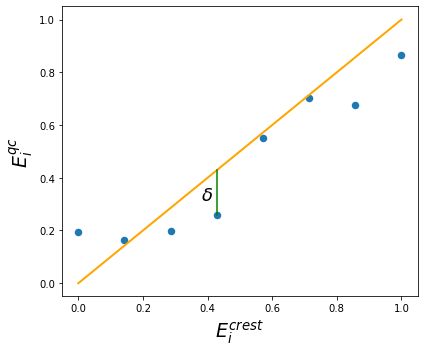

In [93]:
plt.figure(figsize=figsz)

np.random.seed(45)
x = np.linspace(0, 1, 8)
y = x + np.random.uniform(-0.2, 0.2, 8)
y2 = x

plt.scatter(x, y, linewidths=1.5)
plt.plot(x, y2, color='orange', linewidth=2)

index = 3

point_x, point_y = x[index], y[index]

plt.plot([point_x, point_x], [point_y, y2[index]], color='green')

delta_text = r'$\delta$'
plt.text(point_x - 0.03, point_y+0.04, delta_text, fontsize=18, ha='center', va='bottom')

plt.xlabel('$E_i^{crest}$', fontsize=19)
plt.ylabel('$E_i^{qc}$', fontsize=19)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()

plt.savefig('pictures/metric.png', dpi=700)


In [94]:
def hcno_only(smiles):
    mol = pybel.readstring("smi", smiles)
    mol.OBMol.AddHydrogens()
    elems = set([a.atomicnum for a in mol.atoms])
    return elems.issubset({1,6,7,8})



In [95]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 40)
chembl = pd.read_table('SMALL_NEUTRAL.tsv')
chembl = chembl[chembl['Heavy Atoms'] < 20]
chembl = chembl.rename(columns={"Smiles": "smiles"})
chembl

,ChEMBL ID,Name,Synonyms,Type,Max Phase,Molecular Weight,Targets,Bioactivities,AlogP,Polar Surface Area,HBA,HBD,#RO5 Violations,#Rotatable Bonds,Passes Ro3,QED Weighted,CX Acidic pKa,CX Basic pKa,CX LogP,CX LogD,Aromatic Rings,Structure Type,Inorganic Flag,Heavy Atoms,HBA (Lipinski),HBD (Lipinski),#RO5 Violations (Lipinski),Molecular Weight (Monoisotopic),Np Likeness Score,Molecular Species,Molecular Formula,smiles,Inchi Key
2,CHEMBL1870873,NaN,NaN,Small molecule,NaN,217.22,4.0,5.0,1.71,55.40,3,1,0,2,Y,0.77,13.38,None,1.55,1.55,1,MOL,-1,16,4,1,0,217.0739,-0.97,NEUTRAL,C12H11NO3,O=C1OCc2ccc(NC(=O)C3CC3)cc21,RTLHNZVDJGSAMU-UHFFFAOYSA-N
6,CHEMBL1253333,NaN,NaN,Small molecule,NaN,263.37,3.0,3.0,1.86,36.86,3,1,0,2,Y,0.83,11.29,2.00,2.28,2.28,1,MOL,-1,18,4,1,0,263.1092,-0.68,NEUTRAL,C13H17N3OS,CNC(=S)N1CC(C)C(c2ccc(OC)cc2)=N1,NSGKVBWBZYXZMN-UHFFFAOYSA-N
36,CHEMBL161329,NaN,NaN,Small molecule,NaN,234.34,5.0,6.0,3.73,41.13,1,2,0,5,N,0.80,13.90,None,3.67,3.67,1,MOL,-1,17,3,2,0,234.1732,-1.68,NEUTRAL,C14H22N2O,CCCNC(=O)Nc1ccc(C(C)CC)cc1,XNWVKJXAONKXRJ-UHFFFAOYSA-N
50,CHEMBL3785391,NaN,NaN,Small molecule,NaN,234.30,3.0,6.0,1.52,52.57,2,2,0,1,Y,0.77,9.43,None,1.56,1.56,1,MOL,-1,17,4,2,0,234.1368,-0.26,NEUTRAL,C13H18N2O2,CN(C)C(=O)NC1CCc2cc(O)ccc2C1,XNDCARDVIREOCF-UHFFFAOYSA-N
55,CHEMBL163812,NaN,NaN,Small molecule,NaN,238.29,1.0,1.0,2.77,67.59,3,2,0,2,N,0.67,11.49,3.82,2.58,2.58,3,MOL,-1,18,4,3,0,238.1218,-1.22,NEUTRAL,C14H14N4,CCc1ccc(-c2nc3cc(N)ccc3[nH]2)nc1,VAFCWPUGYHLQCI-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1361468,CHEMBL173373,ETHYL PYRUVATE,2-Oxo-Propionic Acid Ethyl Ester|CTI-01|FEMA N...,Small molecule,2.0,116.12,1.0,2.0,0.14,43.37,3,0,0,2,Y,0.38,None,None,0.80,0.80,0,MOL,0,8,3,0,0,116.0473,0.23,NEUTRAL,C5H8O3,CCOC(=O)C(C)=O,XXRCUYVCPSWGCC-UHFFFAOYSA-N
1361476,CHEMBL1089,PHENELZINE,Nardil|PHENELZINE|Phenelzine,Small molecule,4.0,136.20,159.0,768.0,0.69,38.05,2,2,0,3,Y,0.47,None,5.55,1.20,1.20,1,MOL,0,10,2,3,0,136.1000,-0.43,NEUTRAL,C8H12N2,NNCCc1ccccc1,RMUCZJUITONUFY-UHFFFAOYSA-N
1361478,CHEMBL4650230,SIMUFILAM,C-0105|C0105|C0105M|Filora|PTI-125|PTI-910|SIM...,Small molecule,3.0,259.35,NaN,NaN,1.04,35.58,3,1,0,2,Y,0.86,None,8.28,1.43,0.49,1,MOL,0,19,4,1,0,259.1685,-0.38,NEUTRAL,C15H21N3O,CN1CCC2(CC1)NCC(=O)N2Cc1ccccc1,BSQPTZYKCAULBH-UHFFFAOYSA-N
1361481,CHEMBL4297301,METHYL-D9-CHOLINE,2-(TRI(2H3)METHYLAMINIO)ETHANOL|J2.078.736H|ME...,Small molecule,0.5,113.23,NaN,NaN,-0.32,20.23,1,1,0,2,Y,0.48,13.97,None,-4.66,-4.66,0,MOL,0,7,2,1,0,104.1070,1.44,NEUTRAL,C5H14NO+,[2H]C([2H])([2H])[N+](CCO)(C([2H])([2H])[2H])C...,OEYIOHPDSNJKLS-GQALSZNTSA-N


In [96]:
from openbabel import pybel
fltr = chembl['smiles'].apply(hcno_only)
chembl = chembl[fltr]


*** Open Babel Warning  in ParseSmiles
  Ignoring stereochemistry. Not enough connections to this atom. 
*** Open Babel Warning  in CreateCisTrans
  Error in cis/trans stereochemistry specified for the double bond



In [97]:
chembl['model_mpnn'] = chembl['smiles'].apply(predict)
chembl['model_gcn'] = chembl['smiles'].apply(predict_gcn)


/tmp/ipykernel_3175/1977701402.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chembl['model_mpnn'] = chembl['smiles'].apply(predict)
/tmp/ipykernel_3175/1977701402.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chembl['model_gcn'] = chembl['smiles'].apply(predict_gcn)


/tmp/ipykernel_3175/3717986386.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chembl['predicted_metric'] = (chembl['model_mpnn'] + chembl['model_gcn'])/2


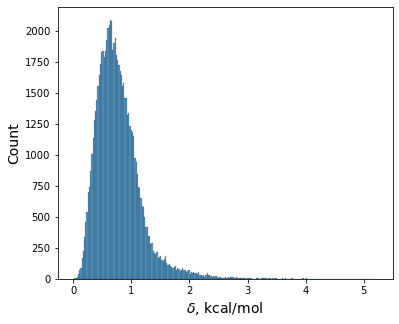

In [98]:
chembl['predicted_metric'] = (chembl['model_mpnn'] + chembl['model_gcn'])/2
plt.figure(figsize=figsz)
sns.histplot(chembl['predicted_metric'])
plt.xlabel("$\delta$, kcal/mol", fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.savefig('pictures/chembl_pr.png', dpi=700)

In [99]:
len(chembl)

74096

In [100]:
predicted_df

,index,Unnamed: 0,coef,Number of conf,Crest max - min,QC max - min,smiles,metric_max,metric_mean,max_diff,mean_diff,omega,file,inchi_key,ChEMBL ID,Heavy Atoms,test,notes,_train_id,model_mpnn,...,Desc_188,Desc_189,Desc_190,Desc_191,Desc_192,Desc_193,Desc_194,Desc_195,Desc_196,Desc_197,Desc_198,Desc_199,Desc_200,model_gb,MPNN_GCN_GB,MPNN_GCN,MPNN_GB,GCN_GB,Predicted_class,Real_class
0,3,3,1.000000,-0.487049,0.005196,0.008041,NCc1ccco1,1.318835,0.723580,1.785256,0.723016,0.000000,3438.0,DDRPCXLAQZKBJP,CHEMBL3561633,7.0,True,ChEMBL,NaN,1.267903,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.560914,1.306803,1.364475,1.431395,1.272622,1.446745,0,0
1,4,4,0.955844,-0.051465,0.009218,0.009905,O=CCCCC=O,1.407707,0.465855,1.628551,0.522030,0.000000,3485.0,SXRSQZLOMIGNAQ,CHEMBL1235482,7.0,True,ChEMBL,NaN,1.815043,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.381710,2.642206,2.068385,1.908476,2.062900,2.114879,1,0
2,5,5,0.481538,0.064690,0.008196,0.011123,CN[C@@H](C)C(=O)O,4.899466,1.223199,6.203820,4.166357,1.533735,4377.0,GDFAOVXKHJXLEI,NaN,7.0,True,random test from PC9,3.0,3.243596,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.503200,3.302943,3.151284,3.144581,3.243115,2.933042,1,1
3,6,6,0.769231,-0.312815,0.003472,0.004438,CCN(CC)N=O,1.050980,0.469052,1.196643,0.644228,0.069052,5921.0,WBNQDOYYEUMPFS,CHEMBL164290,7.0,True,ChEMBL,NaN,1.202215,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.393230,1.876398,1.374949,1.219188,1.405858,1.376029,0,0
4,7,7,0.981818,-0.341854,0.006948,0.013980,[H]/N=C(/N)N=C(N)N,2.808204,1.310002,4.503826,2.806013,0.000000,5939.0,XNCOSPRUTUOJCJ,NaN,7.0,True,random test from PC9,4.0,1.943771,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.211961,2.818363,2.339998,2.245081,2.205695,2.555030,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976,7672,7672,0.900000,-0.164810,0.008630,0.011251,CCN(O)C(N)=O,1.242915,0.790497,NaN,NaN,NaN,3274873.0,NaN,NaN,7.0,True,ChEMBL_7,NaN,1.677706,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.356360,2.127022,1.628183,1.449125,1.808284,1.393313,0,0
1977,7673,7673,0.900000,-0.325105,0.003278,0.006906,OCc1cn[nH]c1,1.870599,0.748239,NaN,NaN,NaN,3276272.0,NaN,NaN,7.0,True,ChEMBL_7,NaN,1.400715,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.515026,0.920366,1.365156,1.575734,1.242380,1.421154,0,0
1978,7674,7674,1.000000,-0.405252,0.001747,0.001732,CN1CC=CC1=O,0.004664,0.004664,NaN,NaN,NaN,3352944.0,NaN,NaN,7.0,True,ChEMBL_7,NaN,0.618249,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.416834,0.741699,0.768999,0.817515,0.653203,0.913699,0,0
1979,7675,7675,1.000000,-0.405252,0.000958,0.002545,CC#CC(=O)NC,0.498483,0.498483,NaN,NaN,NaN,3352947.0,NaN,NaN,7.0,True,ChEMBL_7,NaN,0.789627,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.415005,1.019891,0.881129,0.854870,0.856957,0.914134,0,0


In [101]:
main_csv = pd.read_csv('final_mols_PC9_CHEMBL789_full.csv')

In [102]:
for_pres = main_csv[["smiles", "metric_max"]]
for_pres = for_pres.rename(columns={"metric_max" : 'real delta'})
for_pres = for_pres.sort_values(by='real delta', ascending=False)
for_pres.to_csv("Calculated metric on PC9 and ChEMBL789")

In [103]:
chembl.sort_values(by='predicted_metric', ascending=False)
chembl.to_csv('Predictions on ChEMBL <20HeavyAtoms.csv')

In [104]:
len(chembl)

74096